In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.nn import L1Loss, MSELoss



In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible. Usando CUDA.")
else:
    device = torch.device("cpu")
    print("GPU no disponible, usando CPU.")


GPU disponible. Usando CUDA.


### Cargar dataset

                     consumo
timestamp                   
2015-01-01 00:00:00    25459
2015-01-01 00:10:00    25591
2015-01-01 00:20:00    25531
2015-01-01 00:30:00    25453
2015-01-01 00:40:00    25329


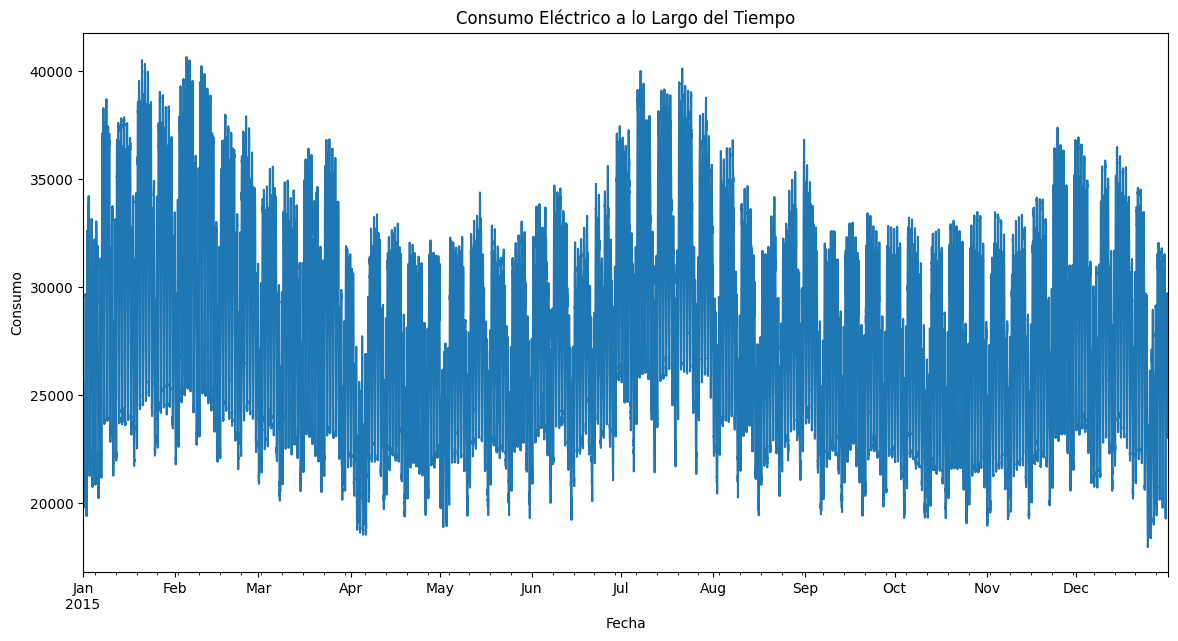

In [4]:
# Cargando el archivo txt
df = pd.read_csv('Demanda_2015.txt', sep='\t', header=None, names=['fecha', 'hora', 'consumo'])

# Combinando las columnas 'fecha' y 'hora' en una sola y convirtiéndolas a datetime
df['timestamp'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'], format='%d/%m/%y %H:%M')

# Estableciendo la columna 'timestamp' como el índice del DataFrame
df.set_index('timestamp', inplace=True)

# Eliminando las columnas originales 'fecha' y 'hora'
df.drop(columns=['fecha', 'hora'], inplace=True)

# Convertir la columna 'consumo' a numérico, por si acaso
df['consumo'] = pd.to_numeric(df['consumo'], errors='coerce')

# Ahora el DataFrame está listo para análisis
print(df.head())

# Realizar un plot sencillo para visualizar los datos
df['consumo'].plot(figsize=(14, 7))
plt.title('Consumo Eléctrico a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.show()


### Creación del modelo

In [5]:
class ElectricConsumptionLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(ElectricConsumptionLSTM, self).__init__()

        # Definir las capas LSTM según la estructura dada
        self.lstm1 = nn.LSTM(input_size, 75, batch_first=True)
        self.lstm2 = nn.LSTM(75, 200, batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm3 = nn.LSTM(200, 275, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm4 = nn.LSTM(275, 225, batch_first=True)
        self.dropout3 = nn.Dropout(0.2)

        # Capa densa final para la salida
        self.dense = nn.Linear(225, output_size)

        self.initialize_weights()


    def forward(self, x):
        # Pasar por la primera LSTM
        x, _ = self.lstm1(x)

        # Pasar por la segunda LSTM y aplicar dropout
        x, _ = self.lstm2(x)
        x = self.dropout1(x)

        # Tercera LSTM y dropout
        x, _ = self.lstm3(x)
        x = self.dropout2(x)

        # Cuarta LSTM y dropout
        x, _ = self.lstm4(x)
        x = self.dropout3(x)

        # Capa densa final para obtener las predicciones
        x = self.dense(x[:, -1, :])  # Solo usamos el último output

        return x
    # Inicialización de los pesos de las capas
    def initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:  # Pesos de las puertas de entrada
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:  # Pesos de las conexiones recurrentes
                init.orthogonal_(param.data)
            elif 'bias' in name:  # Biases inicializadas a 0
                param.data.fill_(0)

            # Inicialización de la capa densa
            if isinstance(param, nn.Linear):
                init.xavier_uniform_(param.weight)
                if param.bias is not None:
                    init.uniform_(param.bias, -0.1, 0.1)

# Definir el tamaño de la entrada y salida (consumo eléctrico y predicciones de 24 pasos en el futuro)
input_size = 1
output_size = 24

model = ElectricConsumptionLSTM(input_size, output_size)
model = model.to(device)
print(model)


ElectricConsumptionLSTM(
  (lstm1): LSTM(1, 75, batch_first=True)
  (lstm2): LSTM(75, 200, batch_first=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (lstm3): LSTM(200, 275, batch_first=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (lstm4): LSTM(275, 225, batch_first=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=225, out_features=24, bias=True)
)


### Creación de secuencias para entrenar y predecir

In [6]:
# Verificar si CUDA está disponible, de lo contrario usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Función adaptada para trabajar con tensores y dispositivos de PyTorch
def create_sequences_with_dates(data, dates, seq_length, pred_length):
    xs, ys, dates_x, dates_y = [], [], [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        x = data[i:(i + seq_length)]
        y = data[(i + seq_length):(i + seq_length + pred_length)]
        date_x = dates[i:(i + seq_length)]
        date_y = dates[(i + seq_length):(i + seq_length + pred_length)]
        xs.append(x)
        ys.append(y)
        dates_x.append(date_x)
        dates_y.append(date_y)
    return np.array(xs), np.array(ys), np.array(dates_x), np.array(dates_y)

# La cantidad de pasos de tiempo que se usarán para predecir el siguiente paso (1 día antes)
seq_length = 24 * 6
# La cantidad de pasos de tiempo a predecir (4 horas)
pred_length = 24
data = df['consumo'].values
dates = df.index.values

X, y, dates_x, dates_y = create_sequences_with_dates(data, dates, seq_length, pred_length)

Usando dispositivo: cuda


### Preprocesado de datos y separación para entrenamiento

In [7]:
# Tamañño de train y test
train_size = int(len(X) * 0.4)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_x_train, dates_x_test = dates_x[:train_size], dates_x[train_size:]
dates_y_train, dates_y_test = dates_y[:train_size], dates_y[train_size:]

# Escalando los datos con MinMaxScaler significa que los valores estarán entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# Reorganizar los datos para que tengan la forma (número de muestras, longitud de la secuencia, número de características)
X_train_scaled = X_train_scaled.reshape((X_train.shape[0], seq_length, 1))
X_test_scaled = X_test_scaled.reshape((X_test.shape[0], seq_length, 1))

# Convertir los datos a tensores de PyTorch y mover al dispositivo
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Configuración de DataLoader, función de pérdida y optimizador
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(dataset, batch_size=512, shuffle=False)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)


### Entrenar Modelo

In [94]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuración del entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
criterion = L1Loss() # Para calcular el MAE
mse_criterion = MSELoss() # Para calcular el MSE
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=0.0001) # Reducir la tasa de aprendizaje si la pérdida de validación no mejora

# Ciclo de entrenamiento con parada temprana
num_epochs = 200 
best_val_loss = np.inf
patience, triggers = 7, 0

for epoch in range(num_epochs):
    train_loss, train_mse = 0.0, 0.0
    model.train()
    for data, target in train_dataloader: # Iterar sobre los datos de entrenamiento
        data, target = data.to(device), target.to(device) # Mover los datos al dispositivo (GPU o CPU)
        optimizer.zero_grad()
        outputs = model(data) # Calcular las predicciones
        loss = criterion(outputs, target) 
        loss.backward() # Calcular los gradientes
        optimizer.step() # Actualizar los pesos
        mse_loss = mse_criterion(outputs, target) 
        train_loss += loss.item()
        train_mse += mse_loss.item()

    # Calculando el promedio de pérdida y MSE en entrenamiento
    train_loss /= len(train_dataloader)
    train_mse /= len(train_dataloader)

    # Paso de validación
    model.eval()
    val_loss, val_mse = 0.0, 0.0
    with torch.no_grad(): # No calcular gradientes en validación
        for data, target in val_dataloader: # Iterar sobre los datos de validación
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            mse_loss = mse_criterion(outputs, target)
            val_loss += loss.item()
            val_mse += mse_loss.item()

    # Calculando el promedio de pérdida y MSE en validación
    val_loss /= len(val_dataloader)
    val_mse /= len(val_dataloader)

    print(f'Epoch {epoch} | Train Loss (MAE): {train_loss} | Train MSE: {train_mse} | Val Loss (MAE): {val_loss} | Val MSE: {val_mse}')

    # Actualizar la tasa de aprendizaje si es necesario
    scheduler.step(val_loss)

    # Parada temprana
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        triggers = 0
    else:
        triggers += 1
        if triggers >= patience:
            print("Early stopping!")
            break



Epoch 0 | Train Loss (MAE): 0.2423121351294401 | Train MSE: 0.09883517635668196 | Val Loss (MAE): 0.16141682310450461 | Val MSE: 0.03609293654200531
Epoch 1 | Train Loss (MAE): 0.16854907317859372 | Train MSE: 0.041300041237618865 | Val Loss (MAE): 0.14609934798171442 | Val MSE: 0.029697631936400168
Epoch 2 | Train Loss (MAE): 0.14874298652497733 | Train MSE: 0.033357231855029014 | Val Loss (MAE): 0.12580995958658955 | Val MSE: 0.02385207013257088
Epoch 3 | Train Loss (MAE): 0.13177259284548642 | Train MSE: 0.0278265098927588 | Val Loss (MAE): 0.09858734232764091 | Val MSE: 0.016785972691591707
Epoch 4 | Train Loss (MAE): 0.11851495740617193 | Train MSE: 0.023087698193948444 | Val Loss (MAE): 0.0957663482235324 | Val MSE: 0.015528893699088404
Epoch 5 | Train Loss (MAE): 0.10137611809300213 | Train MSE: 0.018072306269370928 | Val Loss (MAE): 0.07966682531179921 | Val MSE: 0.01207295791696637
Epoch 6 | Train Loss (MAE): 0.09495350827531117 | Train MSE: 0.016396535969362025 | Val Loss (MA

### Guardar y Cargar Modelo

In [95]:
torch.save(model, 'model.pt')

In [8]:
model = torch.load('model.pt')

### Evaluar Modelo

In [9]:
model.eval()  

predictions = []
with torch.no_grad():  # Para asegurar que no se calculen gradientes
    for X_batch, _ in val_dataloader:
        X_batch = X_batch.to(device)  # Mover el lote al dispositivo
        preds = model(X_batch)
        predictions.append(preds.cpu().numpy())  # Mover las predicciones a CPU y convertir a numpy

# Concatenar todas las predicciones
predictions = np.concatenate(predictions, axis=0)

predictions_inverse = scaler.inverse_transform(predictions.reshape(-1, 24))
y_test_inverse = scaler.inverse_transform(y_test_scaled.reshape(-1, 24))

### Graficar una semana

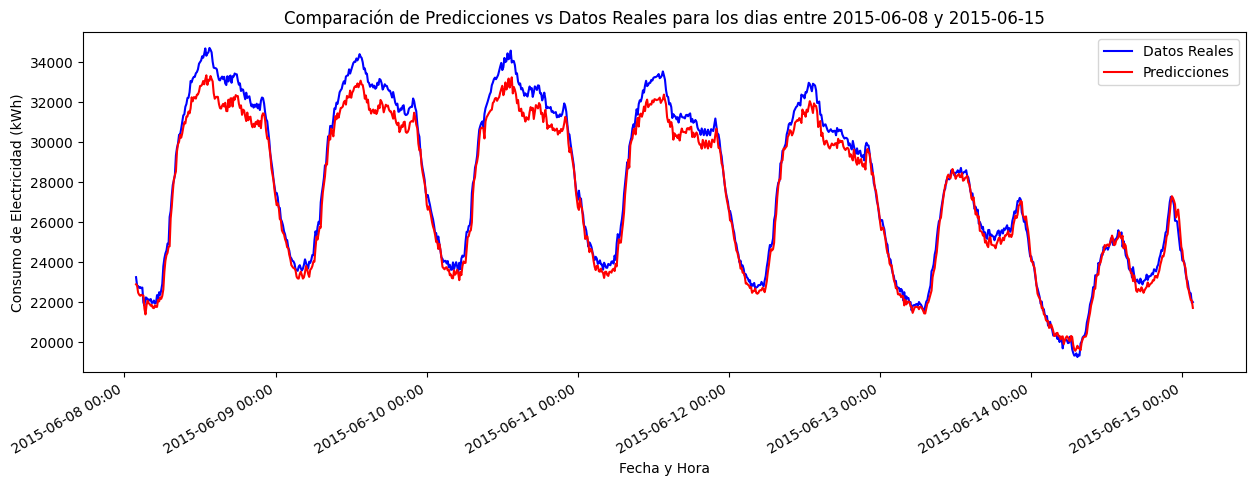

In [10]:
# Extrae solo el primer timestamp de cada bloque de 4 horas para las predicciones, ya que son los mismos
dates_preds = dates_y_test[:, 0]

# Aplana los arrays de predicciones y valores reales para graficar porque están en bloques de 4 horas
preds_flat = predictions_inverse.flatten()
reals_flat = y_test.flatten()

# Convertir todos los timestamps a formato datetime para poder trabajar con ellos más fácilmente
dates = np.array([np.datetime64(time) for sublist in dates_y_test for time in sublist])

# Definir el rango de fechas que deseas graficar
start_index = 1662 * 24
end_index = 2670 * 24

selected_dates = dates[start_index:end_index]
selected_real_data = reals_flat[start_index:end_index]
selected_predictions = preds_flat[start_index:end_index]

plt.figure(figsize=(15, 5))

# Graficar los datos reales
plt.plot(selected_dates[::24], selected_real_data[::24], label='Datos Reales', color='blue', linestyle='-')

# Graficar las predicciones, solo el primer punto de cada bloque para alinear con las fechas iniciales de los bloques
plt.plot(selected_dates[::24], selected_predictions[::24], label='Predicciones', color='red')

# Configurar el formato de las fechas para una mejor visualización
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=24))

plt.title('Comparación de Predicciones vs Datos Reales para los dias entre 2015-06-08 y 2015-06-15')
plt.xlabel('Fecha y Hora')
plt.ylabel('Consumo de Electricidad (kWh)')

plt.legend()

# Rotar las fechas para que se lean mejor
plt.gcf().autofmt_xdate()

plt.show()


### Guardar Resultados

In [11]:
# Crear un DataFrame con los datos
df = pd.DataFrame({
    'Fecha': selected_dates[::24],
    'Datos Reales': selected_real_data[::24],
    'Predicciones': selected_predictions[::24]
})

# Convertir las fechas a formato legible si es necesario (dependerá de cómo estén formateadas tus fechas)
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Guardar el DataFrame en un archivo CSV
df.to_csv('predicciones.csv', index=False)

print("Los datos han sido guardados exitosamente.")


Los datos han sido guardados exitosamente.
